In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
from matplotlib.ticker import MultipleLocator

%matplotlib inline

# re: https://www.cnblogs.com/tina-python/p/5508402.html

In [2]:
# test simple
match = re.match(r'(?P<filename>[a-zA-Z0-9_\.]*[^:]):(?P<line>\d+)', 'RuleEngineLog.h:44')
# match = re.match(r'(?P<function>[a-zA-Z0-9_]*)', 'clips_logd')
match.groupdict()

{'filename': 'RuleEngineLog.h', 'line': '44'}

In [3]:
# 08-31 10:06:09.703  2882  3544 V homebrain: 2034181200 | RuleEngineLog.h:44 | clips_logd | 4 | ("creaate rule context " rul-cloud-virtualmode)
hb_tag=r'homebrain'
p_dt=r'(?P<datetime>\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3})'
p_id1=r'(?P<pthreadid>\d+)'
p_id2=r'(?P<pid>\d+)'
p_id3=r'(?P<kernelpid>\d+)'
p_fnl=r'(?P<filename>[\w\.]*):(?P<line>\d+)'
p_func=r'(?P<function>\w*)'
p_loglevel=r'(?P<level>\d{1})'
p_message=r'(?P<message>.*[^$])'
hb_re = re.compile(p_dt+'\s+'+p_id1+'\s+'+p_id2+' V '+hb_tag+': '+p_id3+' \| '+p_fnl+' \| '+p_func+' \| '+p_loglevel+' \| '+p_message+'$')

# ret = hb_re.search('08-31 10:06:09.703  2882  3544 V homebrain: 2034181200 | RuleEngineLog.h:44 | clips_logd | 4 | (\"creaate rule context \" rul-cloud-virtualmode)')
# print(ret.groupdict())

loginfos = []

def parser(file):
    try:
        with open(file) as f:
            for line in f:
                res = hb_re.search(line)
                if res is None:
                    continue
                loginfos.append(res.groupdict())
                # dt = datetime.strptime(gdict['datetime'], '%m-%d %H:%M:%S.%f').replace(year=2018)
                
    except IOError as e:
        raise e

In [4]:
import os
for f in os.listdir(os.getcwd()):
    if 'logcat.log.' in f:
        parser(f)
log_df = pd.DataFrame(loginfos)
log_df.head()

,datetime,filename,function,kernelpid,level,line,message,pid,pthreadid
0,08-31 09:58:07.505,HBCloudManager.cpp,propertyControl,1970066512,4,33,(surper.virtual.device mode 10)\n,3620,2882
1,08-31 09:58:07.505,lecloud_interface.cpp,lecloud_print,1970066512,4,24,"[LE-INFO-31#09:58:06] send pkt op:503, seq:204...",3620,2882
2,08-31 09:58:07.509,lecloud_interface.cpp,lecloud_print,1970066512,4,24,"[LE-INFO-31#09:58:06] recv pkt op:503, seq:204...",3620,2882
3,08-31 09:58:07.572,RuleEngineCore.cpp,assertRun,2034181200,3,114,((virtualmode 10))\n,3544,2882
4,08-31 09:58:26.439,lecloud_interface.cpp,lecloud_print,1970066512,4,24,"[LE-INFO-31#09:58:25] recv pkt op:504, seq:489...",3620,2882


In [5]:
log_df.drop(columns=['kernelpid'], inplace=True)

In [6]:
# type convert: object to int
log_df['pid'] = log_df['pid'].astype(int)
log_df['pthreadid'] = log_df['pthreadid'].astype(int)
log_df['line'] = log_df['line'].astype(int)
log_df['level'] = log_df['level'].astype(int)
print(log_df.dtypes)

datetime     object
filename     object
function     object
level         int64
line          int64
message      object
pid           int64
pthreadid     int64
dtype: object


In [7]:
# test object to datetime
# datestrs = ['08-31 10:05:05.569','08-31 10:05:05.574']
# test_df = pd.to_datetime(datestrs, format='%m-%d %H:%M:%S.%f')
# print(type(test_df)) # datetimes.DatetimeIdex
# test_df = test_df.map(lambda x: x.strftime('%m-%d %H:%M'))
# print(type(test_df)) # base.Index
# log_df['datetime'] = pd.to_datetime(log_df['datetime'], format='%m-%d %H:%M:%S.%f')
# log_df['datetime'] = log_df['datetime'].apply(lambda x: datetime.strptime(x, '%m-%d %H:%M:%S.%f').replace(year=2018))
# log_df.head()

In [8]:
# this method is wrong why: can not repeatly run this cell, 'datetime' already not string objec
log_df['datetime'] = log_df['datetime'].apply(lambda x: datetime.strptime(x, '%m-%d %H:%M:%S.%f').replace(year=datetime.now().year))
# log_df['datetime'] = pd.to_datetime(log_df['datetime'], format='%m-%d %H:%M:%S.%f')
# log_df.sort_values(by='datetime', ascending=True)
log_df.set_index('datetime', inplace=True)
log_df.sort_index(inplace=True)
log_df.head()

,filename,function,level,line,message,pid,pthreadid
datetime,,,,,,,
2018-08-31 09:54:58.201,lecloud_interface.cpp,lecloud_print,4,24,"[LE-INFO-31#09:54:57] send pkt op:503, seq:193...",3620,2882
2018-08-31 09:54:58.201,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 2)\n,3620,2882
2018-08-31 09:54:58.206,lecloud_interface.cpp,lecloud_print,4,24,"[LE-INFO-31#09:54:57] recv pkt op:503, seq:193...",3620,2882
2018-08-31 09:54:58.212,RuleEngineCore.cpp,assertRun,3,114,((virtualmode 2))\n,3544,2882
2018-08-31 09:54:58.214,RuleEngineService.cpp,callMessagePush,3,336,"(1, 1, rul-001-autolight-service:2, success)\n",3544,2882


In [9]:
# trim/strip str of columns
# %timeit log_df['message'] = log_df['message'].str.strip()
log_df['message'] = log_df['message'].str.strip()
# cost more time
# %timeit log_df.applymap(lambda x : x.strip() if type(x) is str else x)
# %timeit log_df['message'] = log_df['message'].apply(lambda x : x.strip() if type(x) is str else x)
log_df.head()

,filename,function,level,line,message,pid,pthreadid
datetime,,,,,,,
2018-08-31 09:54:58.201,lecloud_interface.cpp,lecloud_print,4,24,"[LE-INFO-31#09:54:57] send pkt op:503, seq:193...",3620,2882
2018-08-31 09:54:58.201,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 2),3620,2882
2018-08-31 09:54:58.206,lecloud_interface.cpp,lecloud_print,4,24,"[LE-INFO-31#09:54:57] recv pkt op:503, seq:193...",3620,2882
2018-08-31 09:54:58.212,RuleEngineCore.cpp,assertRun,3,114,((virtualmode 2)),3544,2882
2018-08-31 09:54:58.214,RuleEngineService.cpp,callMessagePush,3,336,"(1, 1, rul-001-autolight-service:2, success)",3544,2882


In [10]:
# virtual mode search
raw_vm = r'\(surper.virtual.device mode (\d+)\)'
vm_df = log_df[log_df['message'].str.match(raw_vm)]
vm_df.head()

,filename,function,level,line,message,pid,pthreadid
datetime,,,,,,,
2018-08-31 09:54:58.201,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 2),3620,2882
2018-08-31 09:55:16.467,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 1),3620,2882
2018-08-31 09:56:13.787,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 9),3620,2882
2018-08-31 09:56:38.900,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 10),3620,2882
2018-08-31 09:56:49.771,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 9),3620,2882


In [11]:
vm_re = re.compile(raw_vm)

# test re match
match = vm_re.match('(surper.virtual.device mode 1)')
print(type(vm_re), type(match), type(match.group(0)), int(match.group(1)))

# with warning: SettingWitchCopyWarning
# vm_df['vm'] = vm_df['message'].apply(lambda x : int(vm_re.match(x).group(1)))
# inplace is not work
vm_df = vm_df.assign(vm=vm_df['message'].apply(lambda x : int(vm_re.match(x).group(1))), inplace=True)
vm_df.head()

<class '_sre.SRE_Pattern'> <class '_sre.SRE_Match'> <class 'str'> 1


,filename,function,level,line,message,pid,pthreadid,inplace,vm
datetime,,,,,,,,,
2018-08-31 09:54:58.201,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 2),3620,2882,True,2
2018-08-31 09:55:16.467,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 1),3620,2882,True,1
2018-08-31 09:56:13.787,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 9),3620,2882,True,9
2018-08-31 09:56:38.900,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 10),3620,2882,True,10
2018-08-31 09:56:49.771,HBCloudManager.cpp,propertyControl,4,33,(surper.virtual.device mode 9),3620,2882,True,9


In [12]:
vm_df.index.max(), vm_df.index[0], vm_df['vm'].max(), vm_df.vm.min()

(Timestamp('2018-08-31 10:05:05.569000'),
 Timestamp('2018-08-31 09:54:58.201000'),
 10,
 1)

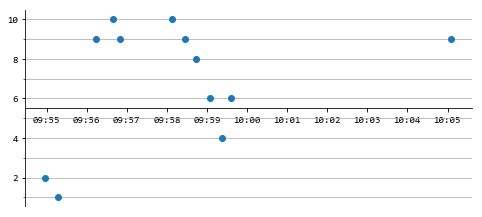

In [20]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

# delta_x = (vm_df.index[-1]-vm_df.index[0])/vm_df.index.size
# delta_y = (vm_df.vm[-1]-vm_df.vm[0])/vm_df.vm.size
# ax.set_ylabel('mode')
# ax.set_xlim([vm_df.index.min()-delta_x, vm_df.index.max()+delta_x])
# ax.set_ylim([vm_df.vm.min()-delta_y, vm_df.vm.max()+delta_y])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 5.5))

# format the ticks
fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator())
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_minor_locator(mdates.MinuteLocator())

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# auto rotate the xaxis label
fig.autofmt_xdate()
ax.plot_date(x=vm_df.index, y=vm_df.vm, xdate=True)
ax.grid(True, which='minor', axis='y')